Question-1: 

Design a proper connected sensor network that covers the area of the plant by using a
reasonable number of sensors. How many do we need to guarantee a connected sensor
network? Motivate your choice.

In [1]:
# This is done by using a Random Geometric Graph
#Reference: 
# 1. https://academic.oup.com/book/9064?login=true
# 2. https://arxiv.org/pdf/1207.2573: formulation for the radius

#https://dl.acm.org/doi/pdf/10.1145/958491.958496

In [2]:
# Import Libraries

from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Beginner Functions

In [4]:
# Essential Functions

# Function to calculate adjacency matrix
def calculate_adjacency_matrix(agent_locations, communication_range):
    num_agents = agent_locations.shape[1]
    adjacency_matrix = np.zeros((num_agents, num_agents), dtype=int)

    for i in range(num_agents):
        for j in range(num_agents):
            if i != j:  # to avoid self-loops
                distance = np.linalg.norm(agent_locations[:, i] - agent_locations[:, j])
                if distance <= communication_range:
                    adjacency_matrix[i, j] = 1

    return adjacency_matrix

# Function to check graph connectivity
def is_graph_connected(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    eigenvalues = np.linalg.eigvalsh(laplacian_matrix)
    zero_eigenvalues = np.sum(np.isclose(eigenvalues, 0))
    return zero_eigenvalues == 1

# Function to create transition matrix P
def generate_uniform_P(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        neighbors = np.where(adjacency_matrix[i] == 1)[0]
        degree = len(neighbors)
        if degree > 0:
            P[i, neighbors] = 1.0 / degree  # Uniform distribution over neighbors
        # If no neighbors, row stays all zero (won't be used anyway)

    return P


Loop: Assuming that r was assumed and n was calculated accordingly

Is network connected? True


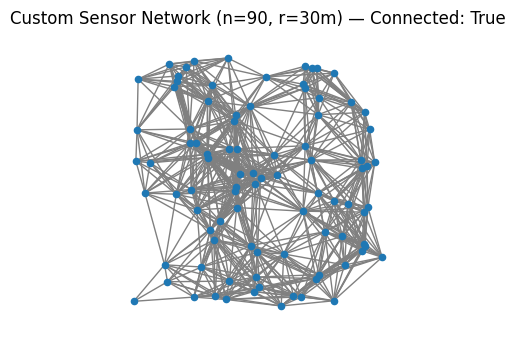

In [53]:
# === Parameters ===
n = 90
area_size = 100
r = 30

# === Generate sensor locations as [2, n] array ===
np.random.seed(50)
positions = np.random.uniform(0, area_size, (n, 2)).T  # shape: [2, n]

# === Calculate adjacency matrix and check connectivity ===
adj_matrix = calculate_adjacency_matrix(positions, r)
connected = is_graph_connected(adj_matrix)

# === Print result ===
print(f"Is network connected? {connected}")

# === Visualize using networkx ===
G = nx.from_numpy_array(adj_matrix)
pos_dict = {i: positions[:, i] for i in range(n)}

plt.figure(figsize=(4.5, 3))
nx.draw(G, pos=pos_dict, node_size=20, edge_color='gray')
plt.title(f"Custom Sensor Network (n={n}, r={r}m) — Connected: {connected}")
plt.axis('equal')
plt.grid(True)
plt.show()


RANDOMISED GOSSIP

In [21]:
np.shape(adj_matrix)

(100, 100)

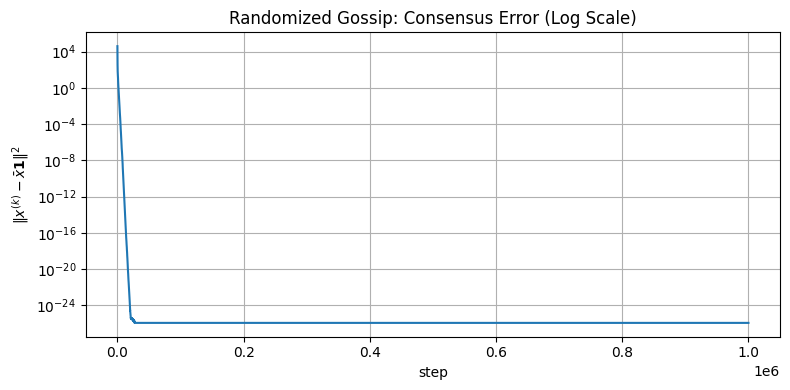

In [49]:
np.random.seed(45)


x0 = np.random.randint(0, 100, (n, 1)) #this generates a vector with random sensor values from 0 to 100. Its a vector with the number of sensors length

x = x0.copy().astype(float)
n = len(x)
avg = np.mean(x)
avg_vec = avg * np.ones((n, 1))
error_rg = []

time_steps=1000000
epislon= 10e-30

for step in range(time_steps):
    
    i = np.random.randint(0, n) #picking a random node in the 100 sensor nodes 
    # print("random node picked", i)

    
    neighbors = []
    #basically for j in all the sensor nodes, if the adjacency matrix has a 1 attached to it, then go for 1 
    for k in range(n):
        if adj_matrix[i, k] == 1:
            neighbors.append(k)

    #so basiclly, in one time step, one node 


    if len(neighbors) == 0:
        continue

    rand_index = np.random.randint(0, len(neighbors))
    j = neighbors[rand_index]

    # Step 5: Compute average and update both i and j
    x_ij_avg = 0.5 * (x[i] + x[j])
    x[i] = x_ij_avg
    x[j] = x_ij_avg

    # Step 6: Compute squared error from consensus
    diff = x - avg_vec
    squared_error = np.linalg.norm(diff)**2
    error_rg.append(squared_error)

    if squared_error < epislon:
        print(f"Stopped at step {step+1} with error {squared_error:.2e}")
        break

plt.figure(figsize=(8, 4))
plt.semilogy(error_rg)
plt.xlabel("step")
plt.ylabel(r"$\|x^{(k)} - \bar{x}\mathbf{1}\|^2$")
plt.title("Randomized Gossip: Consensus Error (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()




In [6]:
# Construct Expected Weight Matrix E[W]
P = generate_uniform_P(adj_matrix)
n = P.shape[0]
W_expected = np.zeros((n, n))
I = np.eye(n)

for i in range(n):
    for j in range(n):
        if P[i, j] > 0:
            v = np.zeros((n, 1))
            v[i] = 1
            v[j] = -1
            Wij = I - 0.5 * (v @ v.T)
            W_expected += (1 / n) * P[i, j] * Wij

print(W_expected)

[[0.99295597 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99300176 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99224941 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99386408 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99288166 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99344807]]


PDMM-Nishita version: Average Consensus

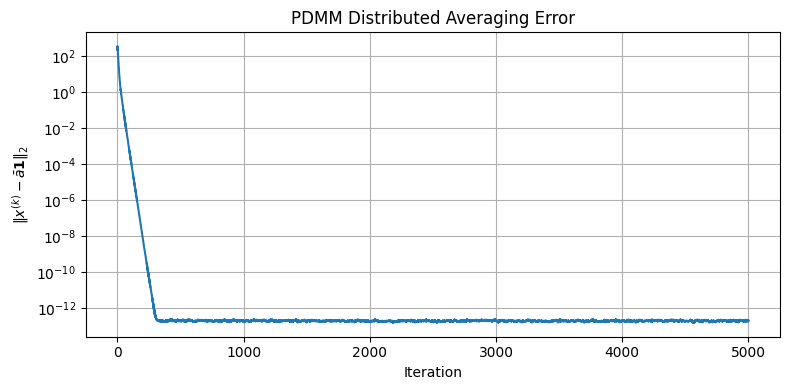

Final error: 2.0691316789454157e-13
Final consensus values (first 10): [45.0889 45.0889 45.0889 45.0889 45.0889 45.0889 45.0889 45.0889 45.0889
 45.0889]
True average: 45.0889


In [59]:
import numpy as np
import matplotlib.pyplot as plt

adj_matrix_modified = adj_matrix.copy()
adj_matrix_modified[adj_matrix_modified == 0] = -1  #this is before we say that Aij=Aji=1 to follow the consensus

n = 90
a = np.random.randint(0, n, size=n)       # initial node values
true_average = np.mean(a)
c = 0.4
iterations = 5000

x = a.astype(float).copy()
z = {}  # dual variables

# Initialize dual variables for all edges
for i in range(n):
    for j in range(n):
        if adj_matrix[i, j] == 1:
            z[(i, j)] = 0.0

x_history = [x.copy()]
error_ac = [np.linalg.norm(x - true_average)]

for k in range(iterations):
    x_new = x.copy()

    # Primal update
    for i in range(n):
        neighbors = [j for j in range(n) if adj_matrix[i, j] == 1]
        d = len(neighbors)
        sum_z = sum(z[(i, j)] for j in neighbors)
        x_new[i] = (a[i] - sum_z) / (1 + c * d)

    # Partial update y
    y = {}
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

    # Flip step !!
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                z[(j, i)] = -y[(i, j)]

    x = x_new.copy()
    x_history.append(x.copy())
    error_ac.append(np.linalg.norm(x - true_average))

# === Plotting ===
plt.figure(figsize=(8, 4))
plt.semilogy(error_ac)
plt.xlabel("Iteration")
plt.ylabel(r"$\|x^{(k)} - \bar{a}\mathbf{1}\|_2$")
plt.title("PDMM Distributed Averaging Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final results ===
print("Final error:", error_ac[-1])
print("Final consensus values (first 10):", np.round(x[:10], 4))
print("True average:", round(true_average, 4))


Q3. Suppose the sensor network would like to compute the median of the measurement
data. Implement the median consensus problem using the PDMM algorithm.

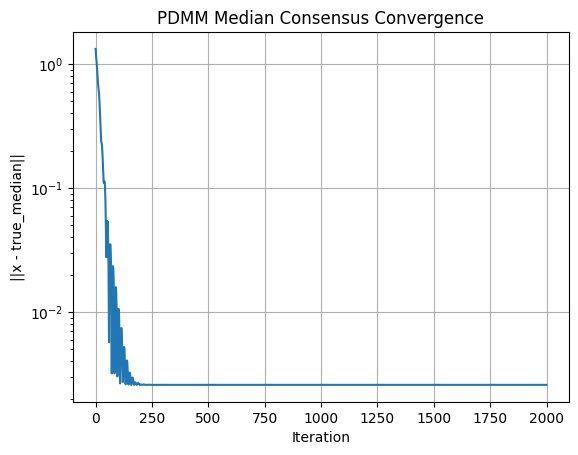

Final error: 0.0025872830304414294
Final node estimates (first 10): [-0.13392205 -0.13392205 -0.13392205 -0.13392205 -0.13392205 -0.13392205
 -0.13392205 -0.13392205 -0.13392205 -0.13392205]
True median: -0.13419477811561714


In [60]:
# --- PDMM MEDIAN CONSENSUS ---

# Use the original 0/1 adjacency matrix to create the graph
G = nx.from_numpy_array(adj_matrix)
n = G.number_of_nodes()
neighbors = {i: list(G.neighbors(i)) for i in G.nodes()}
degrees = np.array([len(neighbors[i]) for i in range(n)])

# Set parameters
c = 1.09
# c_growth = 1.2
iters = 2000

# Initial private data and true median
np.random.seed(45)
s = np.random.randn(n)  # private scalar at each node
true_med = np.median(s)

# 1) Initialization
x = s.copy()
# Duals z_{i|j} are associated with node i's view of the edge (i,j)
z = {(i, j): 0.0 for i in G for j in neighbors[i]}

error_mc = []

# --- PDMM Iterations ---
for k in range(iters):
    x_new = np.zeros_like(x)

    # --- CORRECTED PRIMAL UPDATE ---
    # Implements the three-case function from Eq. (4) with the correct A_ij sign convention
    for i in range(n):
        di = degrees[i]
        if di == 0:
            x_new[i] = s[i]
            continue
        
        # This sum now correctly includes the A_ij sign
        sum_z = sum((1 if i < j else -1) * z[(i, j)] for j in neighbors[i])

        # Define the interval boundaries from Algorithm 1
        bound_1 = (1 - sum_z) / (c * di)
        bound_2 = (-1 - sum_z) / (c * di)

        lower_bound = min(bound_1, bound_2)
        upper_bound = max(bound_1, bound_2)
        
        # Apply the three-case clipping rule
        if s[i] < lower_bound:
            x_new[i] = lower_bound
        elif s[i] > upper_bound:
            x_new[i] = upper_bound
        else:
            x_new[i] = s[i]

    # --- CORRECTED DUAL UPDATE ---
    # Implements the Averaged PDMM update from Eq. (5) with the correct A_ij sign convention
    old_z = z.copy() 
    for i in range(n):
        for j in neighbors[i]:
            # Define A_ij based on the paper's convention
            A_ij = 1 if i < j else -1
            
            # Update the dual variable at node j for the edge coming from i
            # This implements z_{j|i}^{(t+1)} = (1-θ)z_{j|i} + θ * y_{i|j}, with θ=1/2
            # and y_{i|j} = z_{i|j} + 2c*A_ij*x_i
            # Note: The update for z[(j, i)] depends on x_new[i]
            z[(j, i)] = 0.5 * old_z[(j, i)] + 0.5 * (old_z[(i, j)] + 2 * c * A_ij * x_new[i])
            
    # # ADAPTIVE ρ: if progress stalls, grow ρ every 25 iters
    # if k % 25 == 0 and np.max(np.abs(x_new - x)) < 1e-5:
    #     c *= c_growth
    
    x = x_new
    error_mc.append(np.linalg.norm(x - true_med))

# --- Plot convergence and show results ---
plt.semilogy(error_mc)
plt.xlabel('Iteration')
plt.ylabel('||x - true_median||')
plt.title('PDMM Median Consensus Convergence')
plt.grid(True)
plt.show()

print(f"Final error: {error_mc[-1]}")
print(f"Final node estimates (first 10): {x[:10]}")
print(f"True median: {true_med}")

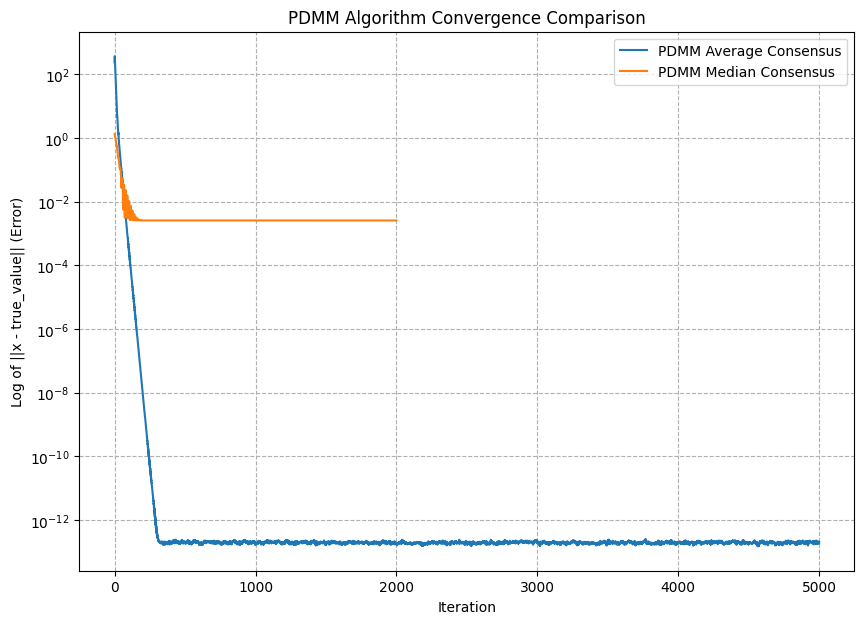

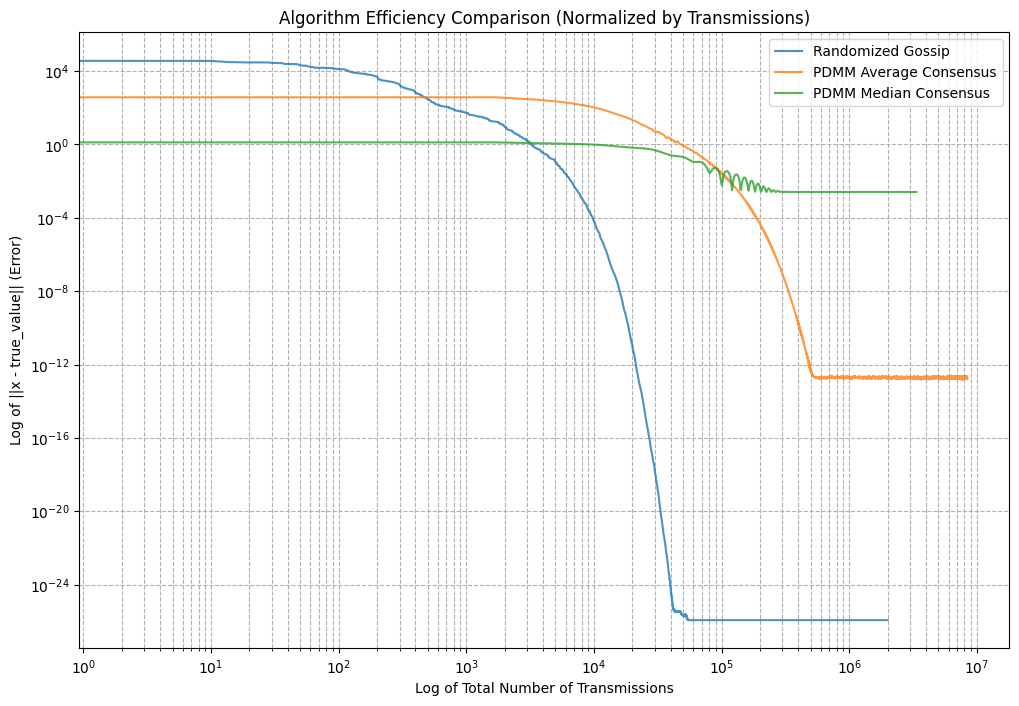

In [61]:
# --- PLOT 1: COMPARING PDMM ALGORITHMS ---

plt.figure(figsize=(10, 7))

# Only plot the two PDMM error histories
plt.semilogy(error_ac, label='PDMM Average Consensus')
plt.semilogy(error_mc, label='PDMM Median Consensus')

plt.title('PDMM Algorithm Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
# --- PLOT 2: NORMALIZED BY NUMBER OF TRANSMISSIONS ---

# Calculate the number of edges in the graph
num_edges = G.number_of_edges()

# Create the x-axis arrays for transmissions
transmissions_rg = np.arange(len(error_rg)) * 2  # 2 transmissions per gossip iteration
transmissions_pdmm_ac = np.arange(len(error_ac)) * (2 * num_edges) # 2*|E| transmissions per PDMM iteration
transmissions_pdmm_mc = np.arange(len(error_mc)) * (2 * num_edges)

plt.figure(figsize=(12, 8))

# Plot error vs. number of transmissions
# Use a log-log plot here to handle the very large x-axis range for transmissions
plt.loglog(transmissions_rg, error_rg, label='Randomized Gossip', alpha=0.8)
plt.loglog(transmissions_pdmm_ac, error_ac, label='PDMM Average Consensus', alpha=0.8)
plt.loglog(transmissions_pdmm_mc, error_mc, label='PDMM Median Consensus', alpha=0.8)

plt.title('Algorithm Efficiency Comparison (Normalized by Transmissions)')
plt.xlabel('Log of Total Number of Transmissions')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()